In [1]:
from sources.bdi_components.plans import PlanLibrary
from sources.bdi_components.belief import BeliefBase, State
from sources.bdi_components.inference import NLIModel
from sources.agent.agent import BDIAgent

from sources.agent.scienceworld import parse_observation

from scienceworld import ScienceWorldEnv
import re
from sources.agent.scienceworld import parse_observation

In [2]:
hg_model_hub_name = "alisawuffles/roberta-large-wanli"
nli_model = NLIModel(hg_model_hub_name)

In [3]:
# MAIN GOAL
main_plan = """
    IF your goal is to boil water THEN
        move to kitchen,
        pick up thermometer,
        get metal pot,
        fill metal pot with water,
        heat water on stove,
        focus on substance in metal pot,
"""

# get metal pot
subplan_a = """
    IF your goal is to get metal pot CONSIDERING you are in the kitchen AND you see a cupboard THEN
        open cupboard,
        pick up metal pot
"""

# fill metal pot with water
subplan_b = """
    IF your goal is to fill metal pot with water CONSIDERING you have metal pot in your inventory AND you see a sink THEN
        move metal pot to sink,
        activate sink,
        deactivate sink,
        pick up metal pot
"""

# heat water on stove
subplan_c = """
    IF your goal is to heat water on stove CONSIDERING you have metal pot with water in your inventory AND you see a stove THEN
        move metal pot to stove,
        activate stove,
        wait,
        use thermometer on metal pot,
        use thermometer on metal pot,
        focus on substance in metal pot,
        wait,
        use thermometer on metal pot
"""

subplan_d = """
    IF your goal is to move to kitchen CONSIDERING you are in hallway THEN
        open door to kitchen,
        go to kitchen
"""

all_plans = [main_plan, subplan_a, subplan_b, subplan_c, subplan_d]

pl = PlanLibrary()
pl.load_plans_from_strings(all_plans)
print(pl.plans.keys())

dict_keys(['boil water', 'get metal pot', 'fill metal pot with water', 'heat water on stove', 'move to kitchen'])


In [4]:
env = ScienceWorldEnv("", "", envStepLimit=100)
randVariationIdx = 0 # water
env.load('boil', randVariationIdx)
# Reset the environment
observation, info = env.reset()

print(f"Task Name: " + 'boil' + " variation " + str(randVariationIdx))
print("Task Description: " + str(env.getTaskDescription()))
randVariationIdx = 0 # tin
env.load('boil', randVariationIdx)
# Reset the environment
observation, info = env.reset()

Task Name: boil variation 0
Task Description: Your task is to boil water. For compounds without a boiling point, combusting the substance is also acceptable. First, focus on the substance. Then, take actions that will cause it to change its state of matter.


In [5]:
def parse(look: str) -> list[str]:
    x = re.search(r"([\S\s]*?)(?:In it, you see:)([\S\s]*?)(?:You also see:)([\S\s]*)", look)
    if x == None:
        x = re.search(r"([\S\s]*?)(?:Here you see:)([\S\s]*?)(?:You also see:)([\S\s]*)", look)
    groups = x.groups()

    location = groups[0]
    objects = groups[1]
    doors = groups[2]

    loc_split = [location.strip()]
    obs_split = [obs.strip() for obs in objects.split('\n') if len(obs.strip()) > 0]
    obs_split = [f"You see {obs}" for obs in obs_split]
    doors_split = [door.strip() for door in doors.split('\n') if len(door.strip()) > 0]
    return loc_split + obs_split + doors_split

In [6]:
observation, reward, isCompleted, info = env.step('look around')
# root_event = env.getTaskDescription().split('.')[0].lower()
root_event = 'boil water'
print(f"Root event: {root_event}")
parsed_obs = parse(info['look'])
inventory = info['inv'].replace('\n', ' ').replace('\t', '')
current_state = State(goal=root_event, observation=observation, look=parsed_obs, inventory=inventory,
                      valid_actions=info['valid'])

Root event: boil water


In [7]:
def step_function(action: str) -> State:
    observation, reward, isCompleted, info = env.step(action)
    parsed_obs = parse(info['look'])
    inventory = info['inv'].replace('\n', ' ').replace('\t', '')

    print(f"Action {action} executed -> obs perceived {observation}")
    return State(goal=root_event, observation=observation, look=parsed_obs, inventory=inventory,
                 valid_actions=info['valid'])

In [8]:
agent = BDIAgent(plan_library=pl, nli_model=nli_model)
agent.act(current_state, step_function=step_function)


print(env.getGoalProgressStr())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Action open door to kitchen executed -> obs perceived The door is now open.
Action go to kitchen executed -> obs perceived You move to the kitchen.
Action pick up thermometer executed -> obs perceived You move the thermometer to the inventory.
Action open cupboard executed -> obs perceived The cupboard is now open.
Action pick up metal pot executed -> obs perceived You move the metal pot to the inventory.
Action move metal pot to sink executed -> obs perceived You move the metal pot to the sink.
Action activate sink executed -> obs perceived The sink is now activated.
Action deactivate sink executed -> obs perceived The sink is now deactivated.
Action pick up metal pot executed -> obs perceived You move the metal pot to the inventory.
Action move metal pot to stove executed -> obs perceived You move the metal pot to the stove.
Action activate stove executed -> obs perceived The stove is now activated.
Action wait executed -> obs perceived You decide to wait for 10 iterations.
Action us

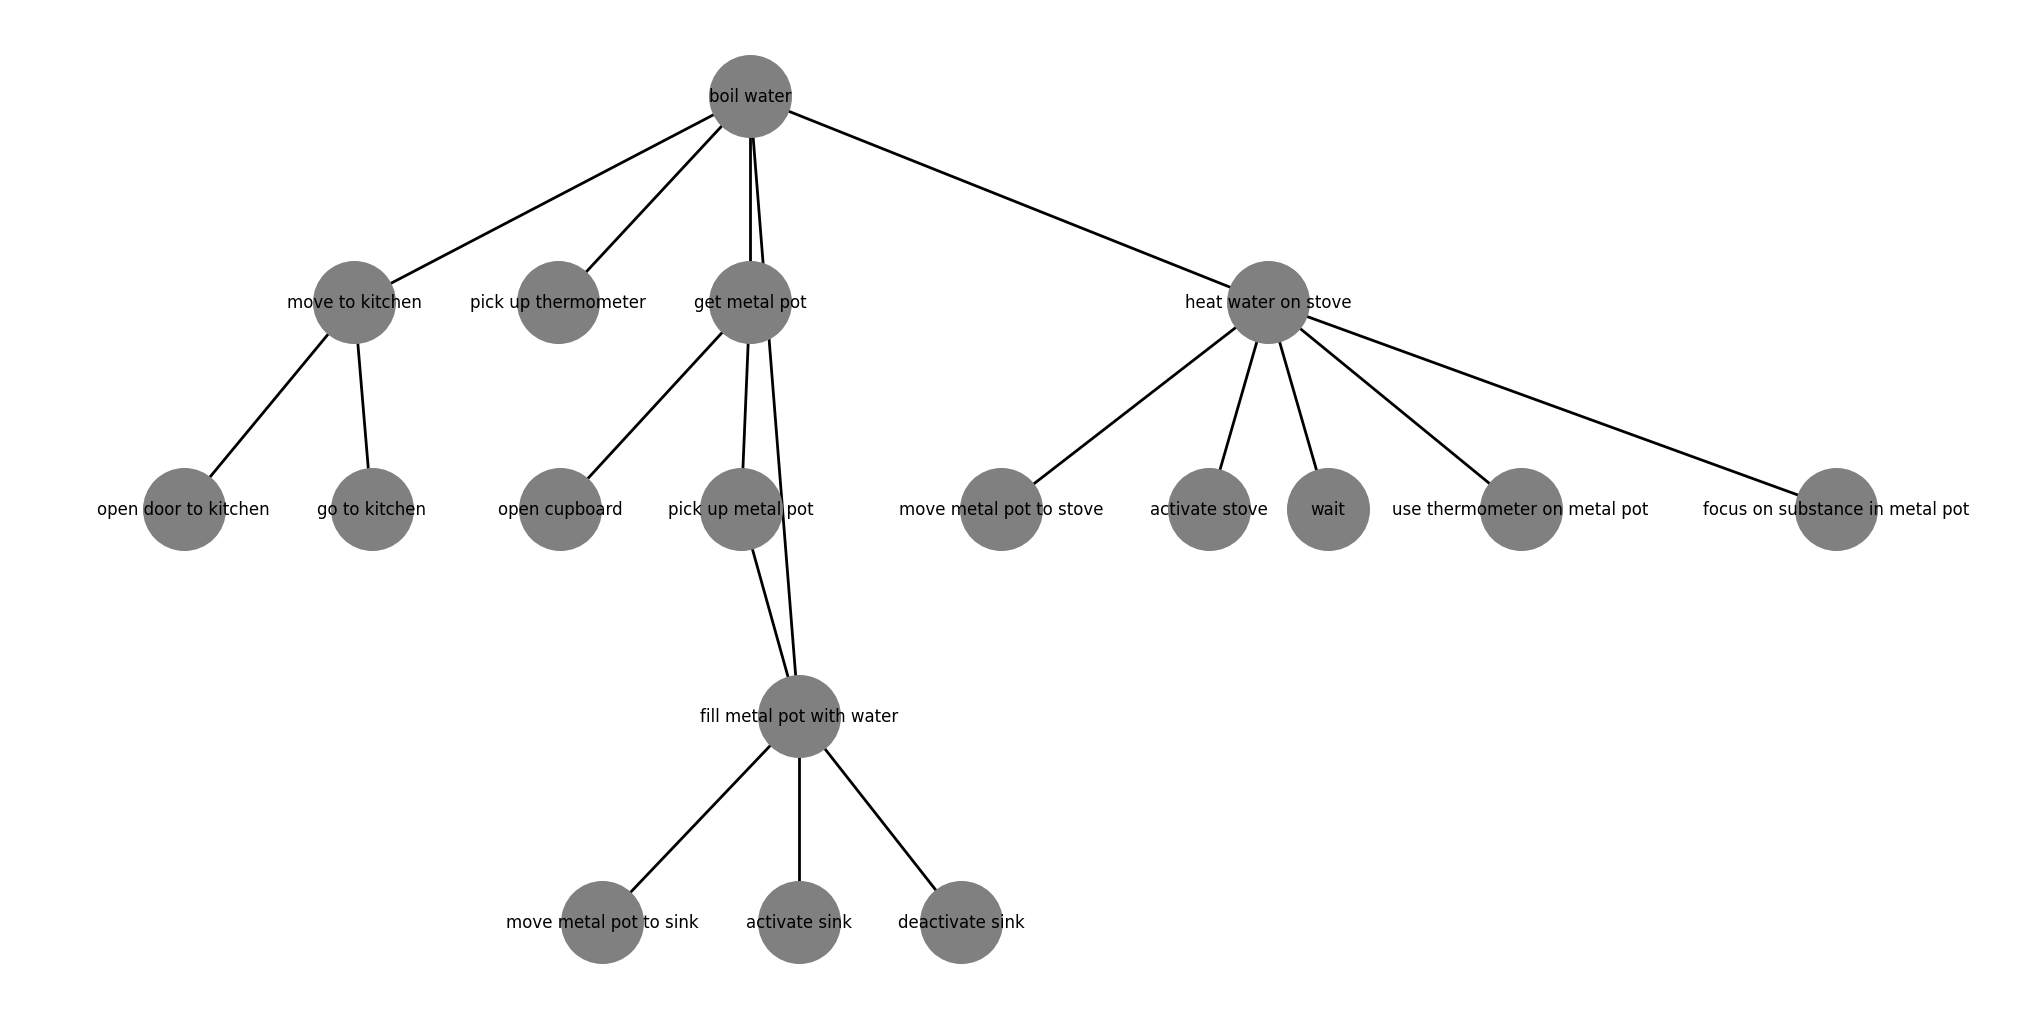

In [32]:

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout



options = {
    "font_size": 12,
    "node_size": 3000,
    "node_color": "gray",
    "edge_color": "black",
    "linewidths": 5,
    "width": 2,
    "min_source_margin":15,
    "min_target_margin":15,
    "with_labels": True
}

plt.figure(figsize=(20,10))
#nx.draw_networkx(agent.plan_tree, **options)
nx.nx_agraph.write_dot(agent.plan_tree,'test.dot')
pos =graphviz_layout(agent.plan_tree, prog="dot")
nx.draw(agent.plan_tree, pos, **options)

# Set margins for the axes so that nodes aren't clipped
#ax = plt.gca()
#ax.margins(.20)

plt.axis("off")
plt.show()